In [1]:
import os
import random

import numpy as np
import torch

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.distributed import DistributedSampler


class DaftExprtDataLoader(Dataset):
    ''' Load PyTorch Data Set
        1) load features, symbols and speaker ID
        2) convert symbols to sequence of one-hot vectors
    '''
    def __init__(self, data_file, hparams, shuffle=True):
        # check data file exists and extract lines
        assert(os.path.isfile(data_file))
        with open(data_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        self.data = [line.strip().split(sep='|') for line in lines]
        self.hparams = hparams
        
        # shuffle
        if shuffle:
            random.seed(hparams.seed)
            random.shuffle(self.data)
    
    def get_mel_spec(self, mel_spec):
        ''' Extract PyTorch float tensor from .npy mel-spec file
        '''
        # transform to PyTorch tensor and check size
        mel_spec = torch.from_numpy(np.load(mel_spec))
        assert(mel_spec.size(0) == self.hparams.n_mel_channels)
        
        return mel_spec
    
    def get_symbols_and_durations(self, markers):
        ''' Extract PyTorch int tensor from an input symbols sequence
            Extract PyTorch float and int duration for each symbol
        '''
        # initialize variables
        symbols, durations_float, durations_int = [], [], []
        
        # read lines of markers file
        with open(markers, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        markers = [line.strip().split(sep='\t') for line in lines]
        
        # iterate over markers
        for marker in markers:
            begin, end, int_dur, symbol, _, _ = marker
            symbols.append(self.hparams.symbols.index(symbol))
            durations_float.append(float(end) - float(begin))
            durations_int.append(int(int_dur))
        
        # convert lists to PyTorch tensors
        symbols = torch.IntTensor(symbols)
        durations_float = torch.FloatTensor(durations_float)
        durations_int = torch.IntTensor(durations_int)
        
        return symbols, durations_float, durations_int
    
    def get_energies(self, energies, speaker_id, normalize=True):
        ''' Extract standardized PyTorch float tensor for energies
        '''
        # read energy lines
        with open(energies, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        energies = np.array([float(line.strip()) for line in lines])
        # standardize energies based on speaker stats
        if normalize:
            zero_idxs = np.where(energies == 0.)[0]
            energies -= self.hparams.stats[f'spk {speaker_id}']['energy']['mean']
            energies /= self.hparams.stats[f'spk {speaker_id}']['energy']['std']
            energies[zero_idxs] = 0.
        # convert to PyTorch float tensor
        energies = torch.FloatTensor(energies)
        
        return energies
    
    def get_pitch(self, pitch, speaker_id, normalize=True):
        ''' Extract standardized PyTorch float tensor for pitch
        '''
        # read pitch lines
        with open(pitch, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        pitch = np.array([float(line.strip()) for line in lines])
        # standardize voiced pitch based on speaker stats
        if normalize:
            zero_idxs = np.where(pitch == 0.)[0]
            pitch -= self.hparams.stats[f'spk {speaker_id}']['pitch']['mean']
            pitch /= self.hparams.stats[f'spk {speaker_id}']['pitch']['std']
            pitch[zero_idxs] = 0.
        # convert to PyTorch float tensor
        pitch = torch.FloatTensor(pitch)
        
        return pitch
    
    def get_data(self, data):
        ''' Extract features, symbols and speaker ID
        '''
        # get mel-spec path, markers path, pitch path and speaker ID
        features_dir = data[0]
        feature_file = data[1]
        speaker_id = int(data[2])
        
        mel_spec = os.path.join(features_dir, f'{feature_file}.npy')
        markers = os.path.join(features_dir, f'{feature_file}.markers')
        symbols_energy = os.path.join(features_dir, f'{feature_file}.symbols_nrg')
        frames_energy = os.path.join(features_dir, f'{feature_file}.frames_nrg')
        symbols_pitch = os.path.join(features_dir, f'{feature_file}.symbols_f0')
        frames_pitch = os.path.join(features_dir, f'{feature_file}.frames_f0')
        
        # extract data
        mel_spec = self.get_mel_spec(mel_spec)
        symbols, durations_float, durations_int = self.get_symbols_and_durations(markers)
        symbols_energy = self.get_energies(symbols_energy, speaker_id)
        frames_energy = self.get_energies(frames_energy, speaker_id, normalize=False)
        symbols_pitch = self.get_pitch(symbols_pitch, speaker_id)
        frames_pitch = self.get_pitch(frames_pitch, speaker_id, normalize=False)
        
        # check everything is correct with sizes
        assert(len(symbols_energy) == len(symbols))
        assert(len(symbols_pitch) == len(symbols))
        assert(len(frames_energy) == mel_spec.size(1))
        assert(len(frames_pitch) == mel_spec.size(1))
        assert(torch.sum(durations_int) == mel_spec.size(1))
        
        return symbols, durations_float, durations_int, symbols_energy, symbols_pitch, \
            frames_energy, frames_pitch, mel_spec, speaker_id, features_dir, feature_file
    
    def __getitem__(self, index):
        return self.get_data(self.data[index])

    def __len__(self):
        return len(self.data)


In [10]:
import sys
PROJECT_ROOT = os.path.dirname(os.path.realpath("."))
sys.path.append(PROJECT_ROOT)

In [11]:
import json
import logging
import os
import sys

from pathlib import Path

from daft_exprt.symbols import pad, symbols_english


_logger = logging.getLogger(__name__)


'''
    Hyper-parameters used for pre-processing and training
'''


class HyperParams(object):
    def __init__(self, verbose=True, **kwargs):
        ''' Initialize hyper-parameter values for data pre-processing and training

        :param verbose:         whether to display logger info/warnings or not
        :param kwargs:          keyword arguments to modify hyper-params values
        '''
        # display some logger info
        if verbose:
            _logger.info('--' * 30)
            _logger.info('Setting Hyper-Parameters'.upper())
            _logger.info('--' * 30)

        ###########################################
        #### hard-coded hyper-parameter values ####
        ###########################################
        # misc hyper-parameters
        self.minimum_wav_duration = 1000  # minimum duration (ms) of the audio files used for training
        
        # mel-spec extraction hyper-parameters
        self.centered = True  # extraction window is centered on the time step when doing FFT
        self.min_clipping = 1e-5  # min clipping value when creating mel-specs
        self.sampling_rate = 22050  # sampling rate of the audios in the data set
        self.mel_fmin = 0  # lowest frequency (in Hz) of the mel-spectrogram
        self.mel_fmax = 8000  # highest frequency (in Hz) of the mel-spectrogram
        self.n_mel_channels = 80  # number of mel bands to generate
        self.filter_length = 1024  # FFT window length (in samples)
        self.hop_length = 256  # length (in samples) between successive analysis windows for FFT
        
        # REAPER pitch extraction hyper-parameters
        self.f0_interval = 0.005
        self.min_f0 = 40
        self.max_f0 = 500
        self.uv_interval = 0.01
        self.uv_cost = 0.9
        self.order = 1
        self.cutoff = 25
        
        # training hyper-parameters
        self.seed = 1234  # seed used to initialize weights
        self.cudnn_enabled = True  # parameter used when initializing training
        self.cudnn_benchmark = False  # parameter used when initializing training
        self.cudnn_deterministic = True  # parameter used when initializing training
        self.dist_backend = 'nccl'  # parameter used to perform distributed training
        self.nb_iterations = 370000  # total number of iterations to perform during training
        self.iters_per_checkpoint = 5000  # number of iterations between successive checkpoints
        self.iters_check_for_model_improvement = 1000 # number of iterations between successive evaluation on the validation set
        self.batch_size = 8  # batch size per GPU card
        self.accumulation_steps = 3  # number of iterations before updating model parameters (gradient accumulation)
        self.checkpoint = ''  # checkpoint to use to restart training at a specific place
        
        # loss weigths hyper-parameters
        self.lambda_reversal = 1.  # lambda multiplier used in reversal gradient layer
        self.adv_max_weight = 1e-2  # max weight to apply on speaker adversarial loss
        self.post_mult_weight = 1e-3  # weight to apply on FiLM scalar post-multipliers
        self.dur_weight = 1.  # weight to apply on duration loss
        self.energy_weight = 1.  # weight to apply on energy loss
        self.pitch_weight = 1.  # weight to apply on pitch loss
        self.mel_spec_weight = 1.  # weight to apply on mel-spec loss
        
        # optimizer hyper-parameters
        self.optimizer = 'adam'  # optimizer to use for training
        self.betas = (0.9, 0.98)  # betas coefficients in Adam
        self.epsilon = 1e-9  # used for numerical stability in Adam
        self.weight_decay = 1e-6  # weight decay (L2 regularization) to use in the optimizer
        self.initial_learning_rate = 1e-4  # value of learning rate at iteration 0
        self.max_learning_rate = 1e-3  # max value of learning rate during training
        self.warmup_steps = 10000  # linearly increase the learning rate for the first warmup steps
        self.grad_clip_thresh = float('inf')  # gradient clipping threshold to stabilize training
        
        # Daft-Exprt module hyper-parameters
        self.prosody_encoder = {
            'nb_blocks': 4,
            'hidden_embed_dim': 128,
            'attn_nb_heads': 8,
            'attn_dropout': 0.1,
            'conv_kernel': 3,
            'conv_channels': 1024,
            'conv_dropout': 0.1
        }
        
        self.phoneme_encoder = {
            'nb_blocks': 4,
            'hidden_embed_dim': 128,
            'attn_nb_heads': 2,
            'attn_dropout': 0.1,
            'conv_kernel': 3,
            'conv_channels': 1024,
            'conv_dropout': 0.1
        }
        
        self.local_prosody_predictor = {
            'nb_blocks': 1,
            'conv_kernel': 3,
            'conv_channels': 256,
            'conv_dropout': 0.1,
        }
        
        self.gaussian_upsampling_module = {
            'conv_kernel': 3
        }
        
        self.frame_decoder = {
            'nb_blocks': 4,
            'attn_nb_heads': 2,
            'attn_dropout': 0.1,
            'conv_kernel': 3,
            'conv_channels': 1024,
            'conv_dropout': 0.1
        }
        
        ######################################################################
        #### hyper-parameter values that have to be specified in **kwargs ####
        ######################################################################
        self.training_files = None  # path to training files
        self.validation_files = None  # path to validation files
        self.output_directory = None  # path to save training outputs (checkpoints, config files, audios, logging ...)

        self.language = None  # spoken language of the speaker(s)
        self.speakers = None  # speakers we want to use for training or transfer learning
        
        ##########################################################################################
        #### hyper-parameter inferred from other hyper-params values or specified in **kwargs ####
        ##########################################################################################
        self.stats = {}  # features stats used during training and inference
        self.symbols = []  # list of symbols used in the specified language
        
        self.n_speakers = 0  # number of speakers to use with a lookup table
        self.speakers_id = []  # ID associated to each speaker -- starts from 0

        ########################################################
        #### update hyper-parameter variables with **kwargs ####
        ########################################################
        for key, value in kwargs.items():
            if hasattr(self, key) and getattr(self, key) is not None and getattr(self, key) != value and verbose:
                _logger.warning(f'Changing parameter "{key}" = {value} (was {getattr(self, key)})')
            setattr(self, key, value)

        # check if all hyper-params have an assigned value
        for param, value in self.__dict__.items():
            assert(value is not None), _logger.error(f'Hyper-parameter "{param}" is None -- please specify a value')

        # give a default value to hyper-parameters that have not been specified in **kwargs
        self._set_default_hyper_params(verbose=verbose)

    def _set_default_hyper_params(self, verbose):
        ''' Give a default value to hyper-parameters that have not been specified in **kwargs

        :param verbose:         whether to display logger info/warnings or not
        '''
        # update MFA paths
        self.update_mfa_paths()
        # set stats if not already set
        stats_file = os.path.join(self.output_directory, 'stats.json')
        if len(self.stats) == 0 and os.path.isfile(stats_file):
            with open(stats_file) as f:
                data = f.read()
            stats = json.loads(data)
            self.stats = stats

        # set symbols if not already set
        if len(self.symbols) == 0:
            if self.language == 'english':
                self.symbols = symbols_english
            else:
                _logger.error(f'Language: {self.language} -- No default value for "symbols" -- please specify a value')
                sys.exit(1)
            if verbose:
                _logger.info(f'Language: {self.language} -- {len(self.symbols)} symbols used')
        # set number of symbols
        self.n_symbols = len(self.symbols)
        # check padding symbol is at index 0
        # zero padding is used in the DataLoader and Daft-Exprt model
        assert(self.symbols.index(pad) == 0), _logger.error(f'Padding symbol "{pad}" must be at index 0')
        
        # set speakers ID if not already set
        if len(self.speakers_id) == 0:
            self.speakers_id = [i for i in range(len(self.speakers))]
            if verbose:
                _logger.info(f'Nb speakers: {len(self.speakers)} -- Changed "speakers_id" to {self.speakers_id}')
        # set n_speakers if not already set
        if self.n_speakers == 0:
            self.n_speakers = len(set(self.speakers_id)) + 1
            if verbose:
                _logger.info(f'Nb speakers: {len(set(self.speakers_id))} -- Changed "n_speakers" to {self.n_speakers}\n')
        
        # check number of speakers is coherent
        assert (self.n_speakers >= len(set(self.speakers_id))), \
            _logger.error(f'Parameter "n_speakers" must be superior or equal to the number of speakers -- '
                          f'"n_speakers" = {self.n_speakers} -- Number of speakers = {len(set(self.speakers_id))}')
        # check items in the lists are unique and have the same size
        assert (len(self.speakers) == len(set(self.speakers))), \
            _logger.error(f'Speakers are not unique: {len(self.speakers)} -- {len(set(self.speakers))}')
        assert (len(self.speakers) == len(self.speakers_id)), \
            _logger.error(f'Parameters "speakers" and "speakers_id" don\'t have the same length: '
                          f'{len(self.speakers)} -- {len(self.speakers_id)}')

        # check FFT/Mel-Spec extraction parameters are correct
        assert(self.filter_length % self.hop_length == 0), _logger.error(f'filter_length must be a multiple of hop_length')
    
    def update_mfa_paths(self):
        ''' Update MFA paths to match the ones in the current environment
        '''
        # paths used by MFA
        home = str(Path.home())
        self.mfa_dictionary = os.path.join(home, 'Documents', 'MFA', 'pretrained_models', 'dictionary', f'{self.language}.dict')
        self.mfa_g2p_model = os.path.join(home, 'Documents', 'MFA', 'pretrained_models', 'g2p', f'{self.language}_g2p.zip')
        self.mfa_acoustic_model = os.path.join(home, 'Documents', 'MFA', 'pretrained_models', 'acoustic', f'{self.language}.zip')
        # check MFA files exist
        assert(os.path.isfile(self.mfa_dictionary)), _logger.error(f'There is no such file "{self.mfa_dictionary}"')
        assert(os.path.isfile(self.mfa_g2p_model)), _logger.error(f'There is no such file "{self.mfa_g2p_model}"')
        assert(os.path.isfile(self.mfa_acoustic_model)), _logger.error(f'There is no such file "{self.mfa_acoustic_model}"')
    
    def save_hyper_params(self, json_file):
        ''' Save hyper-parameters to JSON file
        
        :param json_file:       path of the JSON file to store hyper-parameters
        '''
        # create directory if it does not exists
        dirname = os.path.dirname(json_file)
        os.makedirs(dirname, exist_ok=True)
        # extract hyper-parameters used
        hyper_params = self.__dict__.copy() 
        # save hyper-parameters to JSON file
        with open(json_file, 'w') as f:
            json.dump(hyper_params, f, indent=4, sort_keys=True)


In [13]:
from daft_exprt.model import DaftExprt
from daft_exprt.hparams import HyperParams
import torch
chkpt_path = "/work/tc046/tc046/lordzuko/work/daft-exprt/trainings/daft_bc2013_v1/checkpoints/DaftExprt_best"

def get_model(chkpt_path):
    gpu_available = torch.cuda.is_available()
    if gpu_available:
        checkpoint_dict = torch.load(chkpt_path, map_location=f'cuda:{0}')
    else:
        checkpoint_dict = torch.load(chkpt_path, map_location=f'cpu')

    hparams = HyperParams(verbose=False, **checkpoint_dict['config_params'])
    # load model
    if gpu_available:
        torch.cuda.set_device(0)
        model = DaftExprt(hparams).cuda(0)
    else:
        model = DaftExprt(hparams)

    state_dict = {k.replace('module.', ''): v for k, v in checkpoint_dict['state_dict'].items()}
    model.load_state_dict(state_dict)    

    # define cudnn variables
    random.seed(hparams.seed)
    torch.manual_seed(hparams.seed)
    torch.backends.cudnn.deterministic = True
    _logger.warning('You have chosen to seed training. This will turn on the CUDNN deterministic setting, '
                    'which can slow down your training considerably! You may see unexpected behavior when '
                    'restarting from checkpoints.\n')
    
    return model, hparams

model, hparams = get_model(chkpt_path)

You have chosen to seed training. This will turn on the CUDNN deterministic setting, which can slow down your training considerably! You may see unexpected behavior when restarting from checkpoints.



In [45]:
from torch.utils.data import DataLoader
train_set = DaftExprtDataLoader(hparams.training_files, hparams)
val_set = DaftExprtDataLoader(hparams.validation_files, hparams)
train_loader = DataLoader(train_set)
val_loader = DataLoader(val_set)

In [23]:
hparams.stats

{'spk 0': {'energy': {'max': 3.34,
   'mean': 0.544351240132109,
   'min': 0.001,
   'std': 0.3772718764284442},
  'pitch': {'max': 6.644,
   'mean': 5.245966254782385,
   'min': 4.052,
   'std': 0.23874025392490478}},
 'symbols': {' ': {'dur_max': 4.3,
   'dur_mean': 0.00784778151508248,
   'dur_min': 0.0,
   'dur_std': 0.05450592883311206},
  '!': {'dur_max': 0.0, 'dur_mean': 0.0, 'dur_min': 0.0, 'dur_std': 0.0},
  ',': {'dur_max': 1.5200000000000005,
   'dur_mean': 0.16087323943661974,
   'dur_min': 0.0,
   'dur_std': 0.23441168731333561},
  '.': {'dur_max': 1.7300000000000004,
   'dur_mean': 0.008156860769695748,
   'dur_min': 0.0,
   'dur_std': 0.08217532217907574},
  '?': {'dur_max': 0.0, 'dur_mean': 0.0, 'dur_min': 0.0, 'dur_std': 0.0},
  'AA0': {'dur_max': 0.31000000000000005,
   'dur_mean': 0.10228365384615384,
   'dur_min': 0.02999999999999936,
   'dur_std': 0.04172743888474559},
  'AA1': {'dur_max': 1.02,
   'dur_mean': 0.1049425717852684,
   'dur_min': 0.02999999999999936,


In [184]:
from collections import defaultdict
from tqdm.notebook import tqdm
import numpy as np


def build_stats(loader, hparams):
    stats = defaultdict(dict)
    for x in hparams.symbols:
        stats[x] = defaultdict(dict)
        stats[x]["pitch"] = list()
        stats[x]["energy"] = list()
        stats[x]["duration_f"] = list()
        stats[x]["duration_i"] = list()
        
    for x in tqdm(loader, total=len(loader), desc=">"):
        symbols = x[0].cpu().detach().numpy()
        duration_float = x[1].cpu().detach().numpy()
        duration_int = x[2].cpu().detach().numpy()
        symbols_energy = x[3].cpu().detach().numpy()
        symbols_pitch = x[4].cpu().detach().numpy()

        _, unvoiced_pitch_sym_idx = np.where(symbols_pitch == 0.)
        _, unvoiced_energy_sym_idx = np.where(symbols_energy == 0.)
        
        for i,s in enumerate(symbols[0]):
            sym = hparams.symbols[s]
            
            if i not in unvoiced_pitch_sym_idx:
                stats[sym]["pitch"].append(float(symbols_pitch[0][i]))
            if i not in unvoiced_energy_sym_idx:
                stats[sym]["energy"].append(float(symbols_energy[0][i]))
            stats[sym]["duration_f"].append(float(duration_float[0][i]))
            stats[sym]["duration_i"].append(int(duration_int[0][i]))
    return stats

In [185]:
train_stats = build_stats(train_loader, hparams)
print("--")
val_stats = build_stats(val_loader, hparams)

>:   0%|          | 0/28885 [00:00<?, ?it/s]

--


>:   0%|          | 0/291 [00:00<?, ?it/s]

In [186]:
# import json
# with open('train_stats.json', 'w') as f:
#     json.dump(train_stats, f,indent=4)
# with open('val_stats.json', 'w') as f:
#     json.dump(val_stats, f,indent=4)

In [187]:
train_stats = json.load(open("train_stats.json"))

In [198]:
for x, y in zip(train_stats["ZH"]["duration_f"], train_stats["ZH"]["duration_i"]):
    print(x, y)
    break

0.09000000357627869 8


In [213]:
### Building Stats to be used in the speech editor
STATS = defaultdict(dict)
STATS["gs"] = defaultdict(dict)
STATS["ps"] = defaultdict(dict)
pitch = []
energy = []
duration = []

STATS["ps"]["p"] = defaultdict(dict)
STATS["ps"]["e"] = defaultdict(dict)
STATS["ps"]["d"] = defaultdict(dict)
STATS["gs"]["p"] = defaultdict(dict)
STATS["gs"]["e"] = defaultdict(dict)
STATS["gs"]["d"] = defaultdict(dict)

for s in hparams.symbols:
    
    p = np.exp(sample(np.array(train_stats[s]["pitch"]), pitch_mean, pitch_std))
    if len(p):
        min, max, mean, std = np.min(p), np.max(p), np.mean(p), np.std(p)
    else:
        min, max, mean, std = 0., 0., 0., 0.
    pitch += list(p)
    STATS["ps"]["p"][s] = {}
    STATS["ps"]["p"][s]["min"], STATS["ps"]["p"][s]["max"] = float(min), float(max)
    STATS["ps"]["p"][s]["mean"], STATS["ps"]["p"][s]["std"] = float(mean), float(std)
    
    e = sample(np.array(train_stats[s]["energy"]), energy_mean, energy_std)
    if len(e):
        min, max, mean, std = np.min(e), np.max(e), np.mean(e), np.std(e)
    else:
        min, max, mean, std = 0., 0., 0., 0.
    energy += list(e)
    STATS["ps"]["e"][s] = {}
    STATS["ps"]["e"][s]["min"], STATS["ps"]["e"][s]["max"] = float(min), float(max)
    STATS["ps"]["e"][s]["mean"], STATS["ps"]["e"][s]["std"] = float(mean), float(std)
    
    d = train_stats[s]["duration_i"]
    if len(d):
        min, max, mean, std = np.min(d), np.max(d), np.mean(d), np.std(d)
    else:
        min, max, mean, std = 0., 0., 0., 0.    
    duration += d
    STATS["ps"]["d"][s] = {}
    STATS["ps"]["d"][s]["min"], STATS["ps"]["d"][s]["max"] = float(min), float(max)
    STATS["ps"]["d"][s]["mean"], STATS["ps"]["d"][s]["std"] = float(mean), float(std)

min, max, mean, std = np.min(pitch), np.max(pitch), np.mean(pitch), np.std(pitch)
STATS["gs"]["p"]["min"], STATS["gs"]["p"]["max"] = float(min), float(max)
STATS["gs"]["p"]["mean"], STATS["gs"]["p"]["std"] = float(mean), float(std)
min, max, mean, std = np.min(energy), np.max(pitch), np.mean(energy), np.std(energy)
STATS["gs"]["e"]["min"], STATS["gs"]["e"]["max"] = float(min), float(max)
STATS["gs"]["e"]["mean"], STATS["gs"]["e"]["std"] = float(mean), float(std)
min, max, mean, std = np.min(duration), np.max(duration), np.mean(duration), np.std(duration)
STATS["gs"]["d"]["min"], STATS["gs"]["d"]["max"] = float(min), float(max)
STATS["gs"]["d"]["mean"], STATS["gs"]["d"]["std"] = float(mean), float(std)

In [214]:
STATS

defaultdict(dict,
            {'gs': defaultdict(dict,
                         {'p': defaultdict(dict,
                                      {'min': 57.51236482474955,
                                       'max': 768.161521831313,
                                       'mean': 195.29063611962493,
                                       'std': 47.74770652383254}),
                          'e': defaultdict(dict,
                                      {'min': 0.0010000220059837028,
                                       'max': 768.161521831313,
                                       'mean': 0.5443512401439915,
                                       'std': 0.37727187644034943}),
                          'd': defaultdict(dict,
                                      {'min': 0.0,
                                       'max': 371.0,
                                       'mean': 5.759121252051116,
                                       'std': 5.6100497126005315})}),
             'ps': default

In [215]:
with open('phone_stats.json', 'w') as f:
    json.dump(STATS["ps"], f,indent=4)
with open('global_stats.json', 'w') as f:
    json.dump(STATS["gs"], f,indent=4)

[]

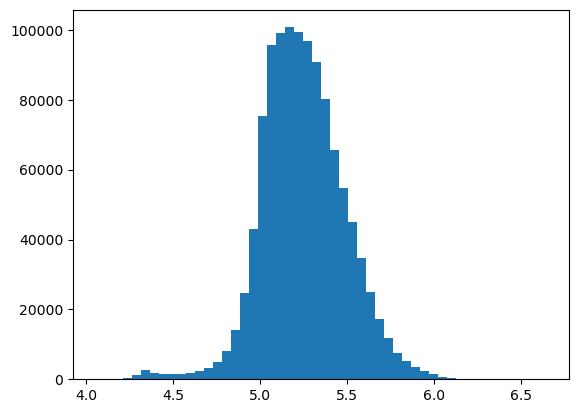

In [189]:
import matplotlib.pyplot as plt
import numpy as np
def sample(x, mean, std):
    return x * std + mean
pitch_mean = hparams.stats["spk 0"]["pitch"]["mean"]
pitch_std = hparams.stats["spk 0"]["pitch"]["std"]
energy_mean = hparams.stats["spk 0"]["energy"]["mean"]
energy_std = hparams.stats["spk 0"]["energy"]["std"]
pitch = []
energy = []
duration = []
for s in hparams.symbols:
    pitch += list(sample(np.array(train_stats[s]["pitch"]), pitch_mean, pitch_std))
plt.hist(pitch, bins=50)
plt.plot()

In [190]:
np.mean(pitch), np.std(pitch), np.min(pitch), np.max(pitch)

(5.2459662547168415,
 0.23874025387446404,
 4.0519999651158525,
 6.644000025919119)

[]

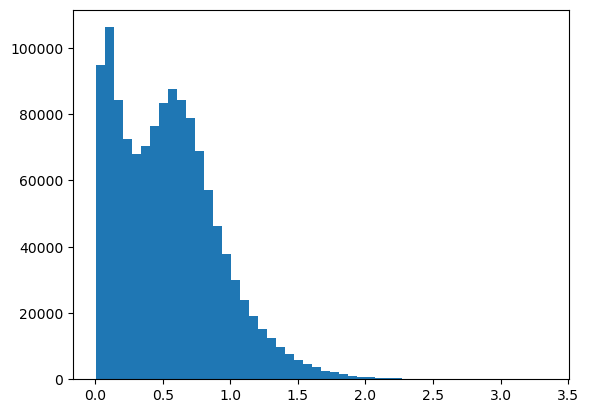

In [191]:
energy = []

for s in hparams.symbols:
    energy += list(sample(np.array(train_stats[s]["energy"]), energy_mean, energy_std))
plt.hist(energy, bins=50)
plt.plot()

In [192]:
np.mean(energy), np.std(energy), np.min(energy), np.max(energy)

(0.5443512401439915,
 0.37727187644034943,
 0.0010000220059837028,
 3.3400000102178056)

[]

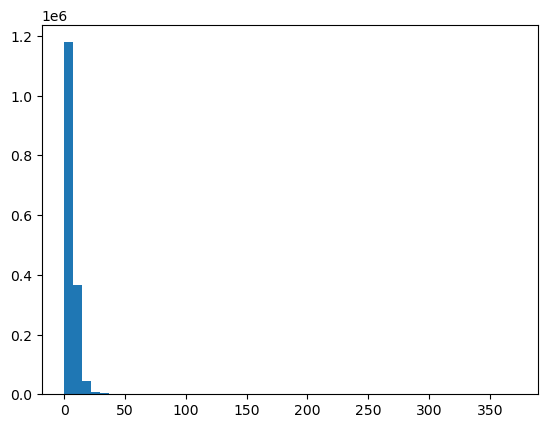

In [193]:
duration_int = []

for s in hparams.symbols:
    duration_int += train_stats[s]["duration_i"]
plt.hist(duration_int, bins=50)
plt.plot()

[]

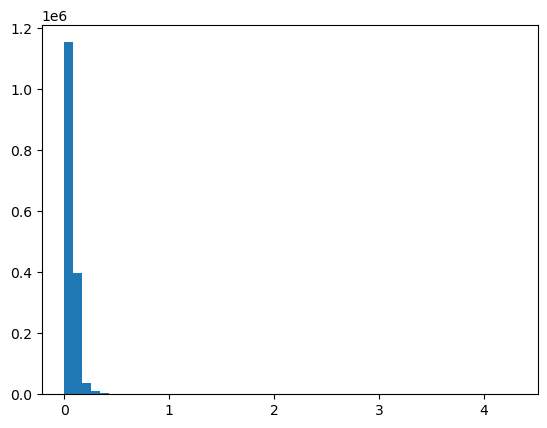

In [194]:
duration_float = []

for s in hparams.symbols:
    duration_float += train_stats[s]["duration_f"]
plt.hist(duration_float, bins=50)
plt.plot()

In [195]:
np.mean(duration_float), np.std(duration_float), np.min(duration_float), np.max(duration_float)

(0.06675896327514481, 0.0649609312187351, 0.0, 4.300000190734863)